# EOBS seasonal means

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from warnings import warn

import cf_xarray as cfxr
import cordex as cx
import dask
import xarray as xr
import xesmf as xe
from dask.distributed import Client
from evaltools import obs
from evaltools.source import get_source_collection, open_and_sort
from evaltools.utils import short_iid

dask.config.set(scheduler="single-threaded")

In [3]:
client = Client(dashboard_address="localhost:8787", threads_per_worker=1)
print(client)

<Client: 'tcp://127.0.0.1:43641' processes=16 threads=16, memory=125.79 GiB>


In [4]:
def add_bounds(ds):
    if "longitude" not in ds.cf.bounds and "latitude" not in ds.cf.bounds:
        ds = cx.transform_bounds(ds, trg_dims=("vertices_lon", "vertices_lat"))
    lon_bounds = ds.cf.get_bounds("longitude")
    lat_bounds = ds.cf.get_bounds("latitude")
    bounds_dim = [dim for dim in lon_bounds.dims if dim not in ds.indexes][0]
    # reshape bounds for xesmf
    ds = ds.assign_coords(
        lon_b=cfxr.bounds_to_vertices(
            lon_bounds, bounds_dim=bounds_dim, order="counterclockwise"
        ),
        lat_b=cfxr.bounds_to_vertices(
            lat_bounds, bounds_dim=bounds_dim, order="counterclockwise"
        ),
    )
    return ds


def mask_with_sftlf(ds, sftlf=None):
    if sftlf is None and "sftlf" in ds:
        sftlf = ds["sftlf"]
        for var in ds.data_vars:
            if var != "sftlf":
                ds[var] = ds[var].where(sftlf > 0)
        ds["mask"] = sftlf > 0
    else:
        warn(f"sftlf not found in dataset: {ds.source_id}")
    return ds


def open_datasets(
    variables, frequency="mon", mask=True, add_missing_bounds=True, **kwargs
):
    cat = get_source_collection(
        variables, frequency, add_fx=["areacella", "sftlf"], **kwargs
    )
    dsets = open_and_sort(cat, merge_fx=True, apply_fixes=True)
    if mask is True:
        for ds in dsets.values():
            mask_with_sftlf(ds)
    if add_missing_bounds is True:
        for dset_id, ds in dsets.items():
            dsets[dset_id] = add_bounds(ds)
    return dsets


def create_cordex_grid(domain_id):
    grid = cx.domain(domain_id, bounds=True, mip_era="CMIP6")
    # grid["lon"].attrs = {}
    # grid["vertices_lat"].attrs = {}
    lon_b = cfxr.bounds_to_vertices(
        grid.vertices_lon, bounds_dim="vertices", order="counterclockwise"
    )
    lat_b = cfxr.bounds_to_vertices(
        grid.vertices_lat, bounds_dim="vertices", order="counterclockwise"
    )
    return grid.assign_coords(lon_b=lon_b, lat_b=lat_b)


def create_regridder(source, target, method="bilinear"):
    regridder = xe.Regridder(source, target, method=method)
    return regridder


def regrid(ds, regridder):
    ds_regrid = regridder(ds)
    for var in ds.data_vars:
        if var not in ["mask", "sftlf"]:
            ds_regrid[var] = ds_regrid[var].where(ds_regrid["mask"] > 0.0)
    return ds_regrid


def regrid_dsets(dsets, target_grid, method="bilinear"):
    for dset_id, ds in dsets.items():
        print(dset_id)
        mapping = ds.cf["grid_mapping"].grid_mapping_name
        if mapping == "rotated_latitude_longitude":
            dsets[dset_id] = ds.cx.rewrite_coords(coords="all")
        else:
            print(f"regridding {dset_id} with grid_mapping: {mapping}")
            regridder = create_regridder(ds, target_grid, method=method)
            print(regridder)
            dsets[dset_id] = regrid(ds, regridder)
    return dsets


def mask_invalid(ds, vars=None, threshold=0.1):
    if isinstance(vars, str):
        vars = [vars]
    if vars is None:
        var = list(ds.data_vars)
    for var in vars:
        var_nan = ds[var].isnull().sum(dim="time") / ds.time.size
        ds[var] = ds[var].where(var_nan < threshold)
    return ds

In [5]:
dsets = open_datasets(
    ["tas"],
    frequency="mon",
    mip_era="CMIP6",
    add_missing_bounds=True,
)

Found: ['ALARO1-SFX', 'CCLM6-0-1-URB', 'CCLM6-0-1-URB-ESG', 'CNRM-ALADIN64E1', 'HCLIM43-ALADIN', 'ICON-CLM-202407-1-1', 'RACMO23E', 'REMO2020'] for variables: ['tas']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'project_id.domain_id.institution_id.driving_source_id.driving_experiment_id.driving_variant_label.source_id.version_realization.frequency.version'


decoding dataset CORDEX-CMIP6.EUR-12.CLMcom-KUL.ERA5.evaluation.r1i1p1f1.CCLM6-0-1-URB-ESG.v1-r1.fx.v20250328
Warning for CORDEX-CMIP6.EUR-12.CLMcom-KUL.ERA5.evaluation.r1i1p1f1.CCLM6-0-1-URB-ESG.v1-r1.fx.v20250328: Variable(s) referenced in bounds not in variables: ['lat_bnds']
Warning for CORDEX-CMIP6.EUR-12.CLMcom-KUL.ERA5.evaluation.r1i1p1f1.CCLM6-0-1-URB-ESG.v1-r1.fx.v20250328: Variable(s) referenced in bounds not in variables: ['lon_bnds']
Warning for CORDEX-CMIP6.EUR-12.CLMcom-KUL.ERA5.evaluation.r1i1p1f1.CCLM6-0-1-URB-ESG.v1-r1.fx.v20250328: Variable(s) referenced in cell_measures not in variables: ['area']
Found 16 datasets
decoding dataset CORDEX-CMIP6.EUR-12.CLMcom-KUL.ERA5.evaluation.r1i1p1f1.CCLM6-0-1-URB-ESG.v1-r1.mon.v20250328
Warning for CORDEX-CMIP6.EUR-12.CLMcom-KUL.ERA5.evaluation.r1i1p1f1.CCLM6-0-1-URB-ESG.v1-r1.mon.v20250328: Variable(s) referenced in cell_measures not in variables: ['area']
Warning for CORDEX-CMIP6.EUR-12.CLMcom-KUL.ERA5.evaluation.r1i1p1f1.CCLM6-

/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/evalbook-remote/lib/python3.13/site-packages/evaltools/fix.py:44: UserWarning: Grid mapping name crs is not supported
  warnings.warn(f"Grid mapping name {grid_mapping_name} is not supported")
/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/evalbook-remote/lib/python3.13/site-packages/evaltools/fix.py:39: UserWarning: Variables {'height'} not found in object but are referred to in the CF attributes.
  grid_mapping_varname = ds.cf["grid_mapping"].name
/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/evalbook-remote/lib/python3.13/site-packages/evaltools/fix.py:44: UserWarning: Grid mapping name crs is not supported
  warnings.warn(f"Grid mapping name {grid_mapping_name} is not supported")


Fix failed for CORDEX-CMIP6.EUR-12.CLMcom-KUL.ERA5.evaluation.r1i1p1f1.CCLM6-0-1-URB-ESG.v1-r1.fx.v20250328: Grid mapping name crs is not supported
Dataset CORDEX-CMIP6.EUR-12.CLMcom-KUL.ERA5.evaluation.r1i1p1f1.CCLM6-0-1-URB-ESG.v1-r1.fx.v20250328 will be ignored...
Warning for CORDEX-CMIP6.EUR-12.CLMcom-KUL.ERA5.evaluation.r1i1p1f1.CCLM6-0-1-URB-ESG.v1-r1.mon.v20250328: Variables {'height'} not found in object but are referred to in the CF attributes.
Fix failed for CORDEX-CMIP6.EUR-12.CLMcom-KUL.ERA5.evaluation.r1i1p1f1.CCLM6-0-1-URB-ESG.v1-r1.mon.v20250328: Grid mapping name crs is not supported
Dataset CORDEX-CMIP6.EUR-12.CLMcom-KUL.ERA5.evaluation.r1i1p1f1.CCLM6-0-1-URB-ESG.v1-r1.mon.v20250328 will be ignored...
Renaming grid mapping variable rotated_pole to 'crs'
Renaming grid mapping variable rotated_pole to 'crs'
Renaming grid mapping variable rotated_latitude_longitude to 'crs'
Renaming grid mapping variable rotated_latitude_longitude to 'crs'


/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/evalbook-remote/lib/python3.13/site-packages/evaltools/fix.py:44: UserWarning: Grid mapping name latitude_longitude is not supported
  warnings.warn(f"Grid mapping name {grid_mapping_name} is not supported")
/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/evalbook-remote/lib/python3.13/site-packages/evaltools/fix.py:44: UserWarning: Grid mapping name latitude_longitude is not supported
  warnings.warn(f"Grid mapping name {grid_mapping_name} is not supported")


Fix failed for CORDEX-CMIP6.EUR-12.CNRM-MF.ERA5.evaluation.r1i1p1f1.CNRM-ALADIN64E1.v1-r1.fx.v20250116: Grid mapping name latitude_longitude is not supported
Dataset CORDEX-CMIP6.EUR-12.CNRM-MF.ERA5.evaluation.r1i1p1f1.CNRM-ALADIN64E1.v1-r1.fx.v20250116 will be ignored...
Renaming grid mapping variable rotated_latitude_longitude to 'crs'
Fix failed for CORDEX-CMIP6.EUR-12.CNRM-MF.ERA5.evaluation.r1i1p1f1.CNRM-ALADIN64E1.v1-r1.mon.v20250116: Grid mapping name latitude_longitude is not supported
Dataset CORDEX-CMIP6.EUR-12.CNRM-MF.ERA5.evaluation.r1i1p1f1.CNRM-ALADIN64E1.v1-r1.mon.v20250116 will be ignored...
Renaming grid mapping variable rotated_latitude_longitude to 'crs'
merging CORDEX-CMIP6.EUR-12.CLMcom-CMCC.ERA5.evaluation.r1i1p1f1.CCLM6-0-1-URB.v1-r1.mon.v20250201 with CORDEX-CMIP6.EUR-12.CLMcom-CMCC.ERA5.evaluation.r1i1p1f1.CCLM6-0-1-URB.v1-r1.fx.v20250201
merging CORDEX-CMIP6.EUR-12.HCLIMcom-SMHI.ERA5.evaluation.r1i1p1f1.HCLIM43-ALADIN.v1-r1.mon.v20241205 with CORDEX-CMIP6.EUR-

In [6]:
rotated_grid = create_cordex_grid("EUR-11")
dsets = regrid_dsets(dsets, rotated_grid, method="bilinear")

CORDEX-CMIP6.EUR-12.CLMcom-CMCC.ERA5.evaluation.r1i1p1f1.CCLM6-0-1-URB.v1-r1.mon.v20250201
CORDEX-CMIP6.EUR-12.HCLIMcom-SMHI.ERA5.evaluation.r1i1p1f1.HCLIM43-ALADIN.v1-r1.mon.v20241205
regridding CORDEX-CMIP6.EUR-12.HCLIMcom-SMHI.ERA5.evaluation.r1i1p1f1.HCLIM43-ALADIN.v1-r1.mon.v20241205 with grid_mapping: lambert_conformal_conic


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_453x453_412x424.nc 
Reuse pre-computed weights? False 
Input grid shape:           (453, 453) 
Output grid shape:          (412, 424) 
Periodic in longitude?      False


CORDEX-CMIP6.EUR-12.KNMI.ERA5.evaluation.r1i1p1f1.RACMO23E.v1-r1.mon.v20241216
CORDEX-CMIP6.EUR-12.RMIB-UGent.ERA5.evaluation.r1i1p1f1.ALARO1-SFX.v1-r1.mon.v20241009
regridding CORDEX-CMIP6.EUR-12.RMIB-UGent.ERA5.evaluation.r1i1p1f1.ALARO1-SFX.v1-r1.mon.v20241009 with grid_mapping: lambert_conformal_conic


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_483x483_412x424.nc 
Reuse pre-computed weights? False 
Input grid shape:           (483, 483) 
Output grid shape:          (412, 424) 
Periodic in longitude?      False
CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020.v1-r1.mon.v20241120
CORDEX-CMIP6.EUR-12.CLMcom-Hereon.ERA5.evaluation.r1i1p1f1.ICON-CLM-202407-1-1.v1-r1.mon.v20240920


In [7]:
period = slice("1980", "2020")

eobs = obs.eobs(add_mask=False).sel(time=period)
eobs = mask_invalid(eobs, vars="tg", threshold=0.1)

In [8]:
# unmapped_to_nan, see https://github.com/pangeo-data/xESMF/issues/56
regridder = xe.Regridder(eobs, rotated_grid, method="bilinear", unmapped_to_nan=True)
eobs_on_rotated = regridder(eobs)

In [9]:
def seasonal_mean(da):
    """Optimized function to calculate seasonal averages from time series of monthly means

    based on: https://xarray.pydata.org/en/stable/examples/monthly-means.html
    """
    # Get number od days for each month
    month_length = da.time.dt.days_in_month
    # Calculate the weights by grouping by 'time.season'.
    weights = (
        month_length.groupby("time.season") / month_length.groupby("time.season").sum()
    )

    # Test that the sum of the weights for each season is 1.0
    # np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))

    # Calculate the weighted average
    return (
        (da * weights).groupby("time.season").sum(dim="time", skipna=True, min_count=1)
    )

In [10]:
%%time

eobs_seasmean = seasonal_mean(eobs_on_rotated.tg.sel(time=period)).compute()

/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/evalbook-remote/lib/python3.13/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 15.54 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 6.16 s, sys: 1.65 s, total: 7.81 s
Wall time: 44.5 s


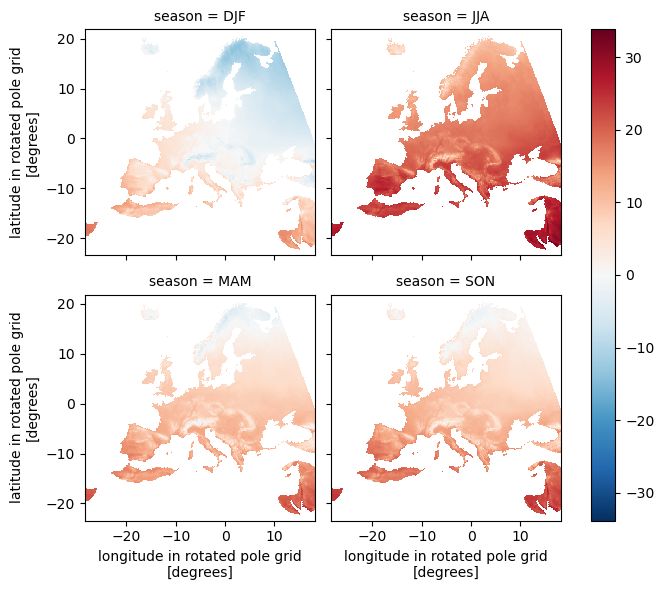

In [11]:
eobs_seasmean.plot(col="season", col_wrap=2)

In [12]:
variable = "tas"

diffs = {
    dset_id: seasonal_mean(ds[[variable]].sel(time=period)).compute()
    - (eobs_seasmean + 273.15)
    for dset_id, ds in dsets.items()
}
seasonal_bias = xr.concat(
    list(diffs.values()),
    dim=xr.DataArray(
        list(
            map(
                lambda x: short_iid(x, ["institution_id", "source_id"], delimiter="-"),
                diffs.keys(),
            )
        ),
        dims="dset_id",
    ),
    compat="override",
    coords="minimal",
)

/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/evalbook-remote/lib/python3.13/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 9.64 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/evalbook-remote/lib/python3.13/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 9.54 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [13]:
seasonal_bias

<xarray.Dataset> Size: 37MB
Dimensions:    (dset_id: 6, season: 4, rlat: 412, rlon: 424)
Coordinates:
  * rlon       (rlon) float64 3kB -28.38 -28.27 -28.16 ... 17.93 18.05 18.16
  * rlat       (rlat) float64 3kB -23.38 -23.27 -23.16 ... 21.61 21.73 21.84
    lon        (rlat, rlon) float64 1MB -10.06 -9.964 -9.864 ... 64.76 64.96
    lat        (rlat, rlon) float64 1MB 21.99 22.03 22.07 ... 66.81 66.75 66.69
  * season     (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'
    areacella  (rlat, rlon) float32 699kB 1.373e+08 1.373e+08 ... 1.389e+08
  * dset_id    (dset_id) <U33 792B 'CLMcom-CMCC-CCLM6-0-1-URB' ... 'CLMcom-He...
Data variables:
    tas        (dset_id, season, rlat, rlon) float64 34MB nan nan ... nan nan
Attributes: (12/49)
    Conventions:                             CF-1.11
    conventionsURL:                          http://www.cfconventions.org
    title:                                   CLMcom-CMCC COSMO model outputs ...
    project_id:                              CORDEX
    CORDEX_domain:                           EUR-12
    driving_model_id:                        ERA5
    ...                                      ...
    intake_esm_attrs:version:                v20250201
    intake_esm_attrs:time_range:             198001-198012
    intake_esm_attrs:variable_id:            tas
    intake_esm_attrs:path:                   /mnt/CORDEX_CMIP6_tmp/sim_data/C...
    intake_esm_attrs:_data_format_:          netcdf
    intake_esm_dataset_key:                  CORDEX-CMIP6.EUR-12.CLMcom-CMCC....

/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/evalbook-remote/lib/python3.13/site-packages/cf_xarray/accessor.py:718: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  unused_keys = set(attribute.keys()) - set(inverted)
/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/evalbook-remote/lib/python3.13/site-packages/cf_xarray/accessor.py:719: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for key, value in attribute.items():
<frozen _collections_abc>:899: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more c

aspect: 0.9716981132075472
0 0 0 DJF CLMcom-CMCC-CCLM6-0-1-URB


0 1 4 DJF HCLIMcom-SMHI-HCLIM43-ALADIN
0 2 8 DJF KNMI-RACMO23E
0 3 12 DJF RMIB-UGent-ALARO1-SFX


0 4 16 DJF GERICS-REMO2020
0 5 20 DJF CLMcom-Hereon-ICON-CLM-202407-1-1
1 0 1 JJA CLMcom-CMCC-CCLM6-0-1-URB
1 1 5 JJA HCLIMcom-SMHI-HCLIM43-ALADIN


1 2 9 JJA KNMI-RACMO23E
1 3 13 JJA RMIB-UGent-ALARO1-SFX
1 4 17 JJA GERICS-REMO2020


1 5 21 JJA CLMcom-Hereon-ICON-CLM-202407-1-1
2 0 2 MAM CLMcom-CMCC-CCLM6-0-1-URB
2 1 6 MAM HCLIMcom-SMHI-HCLIM43-ALADIN
2 2 10 MAM KNMI-RACMO23E


2 3 14 MAM RMIB-UGent-ALARO1-SFX
2 4 18 MAM GERICS-REMO2020
2 5 22 MAM CLMcom-Hereon-ICON-CLM-202407-1-1


3 0 3 SON CLMcom-CMCC-CCLM6-0-1-URB
3 1 7 SON HCLIMcom-SMHI-HCLIM43-ALADIN
3 2 11 SON KNMI-RACMO23E
3 3 15 SON RMIB-UGent-ALARO1-SFX


3 4 19 SON GERICS-REMO2020
3 5 23 SON CLMcom-Hereon-ICON-CLM-202407-1-1


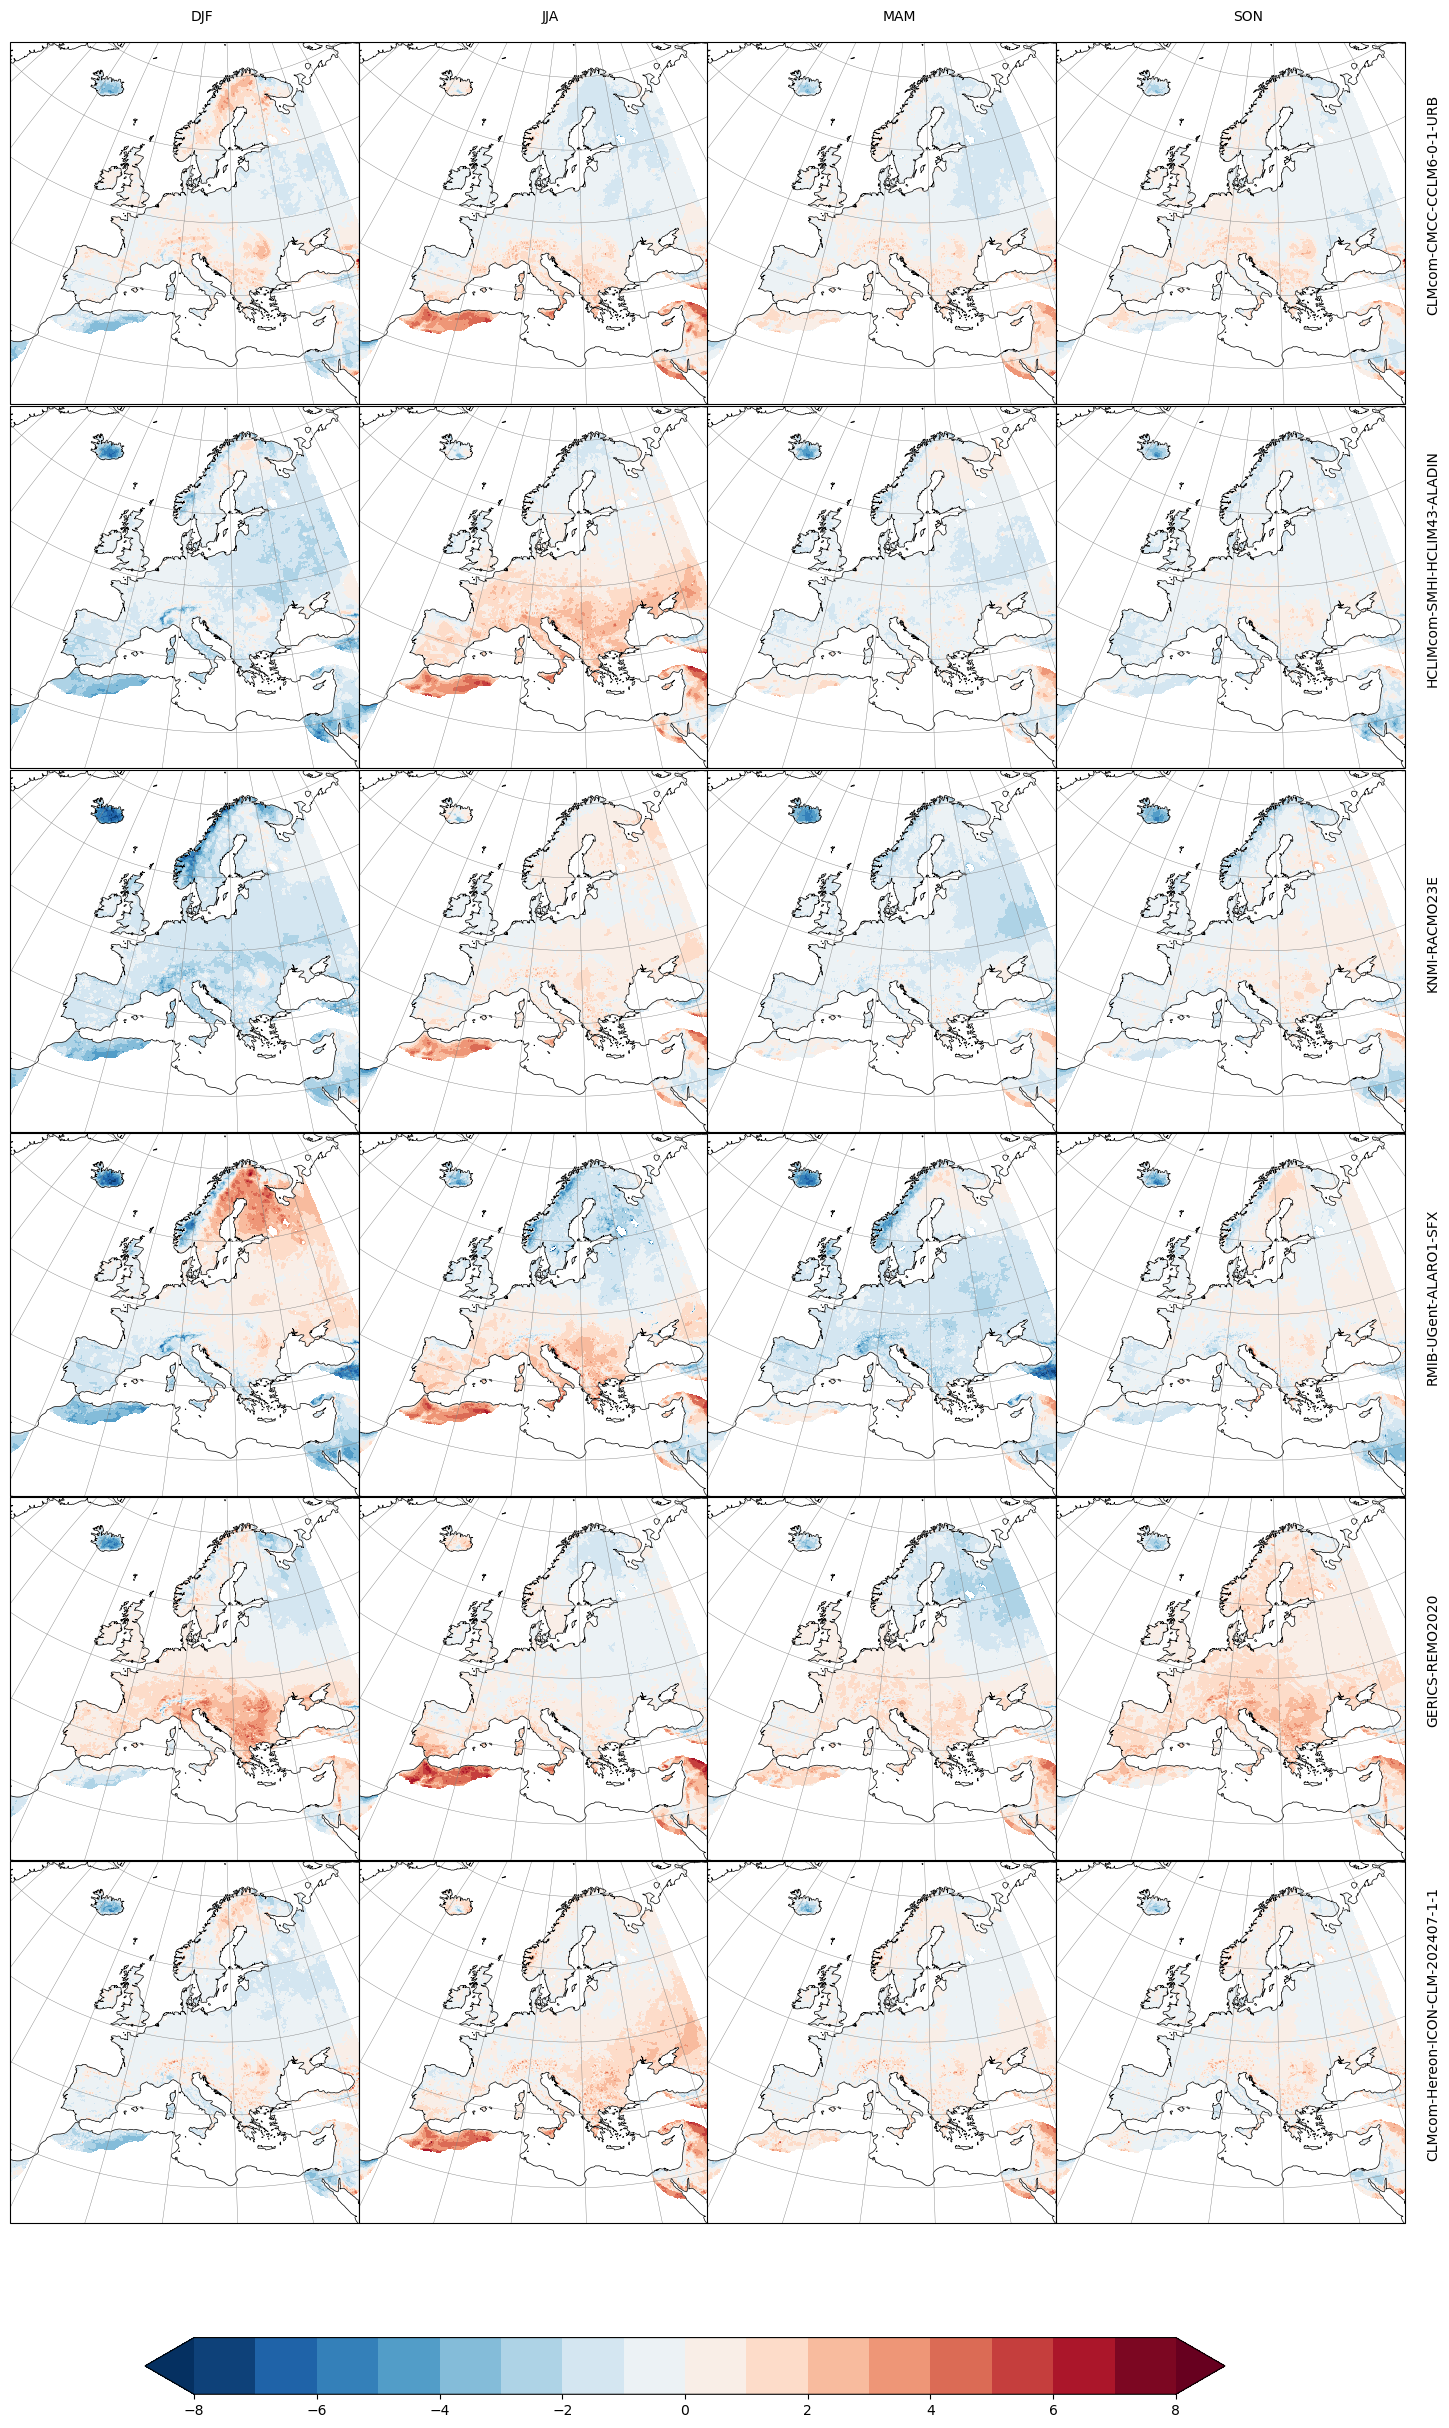

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from cartopy import crs as ccrs
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter

ds = seasonal_bias

nrows = ds.dset_id.size
ncols = ds.season.size

aspect = ds.cf.dims["Y"] / ds.cf.dims["X"]
print(f"aspect: {aspect}")
# ds = diffs.where(~diffs.isnull(), drop=True)
tas = ds.tas
# pole = ds.cf["grid_mapping"]
# transform = ccrs.RotatedPole(
#    pole_latitude=pole.grid_north_pole_latitude,
#    pole_longitude=pole.grid_north_pole_longitude,
# )
transform = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162.0)
projection = transform

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    subplot_kw={"projection": projection},
    figsize=(18, 18 * 1.05 * nrows / ncols),
    sharex=True,
    sharey=True,
    gridspec_kw={"wspace": 0, "hspace": 0},
    #  aspect_ratio=0.97,
)

# plt.subplots_adjust(wspace=0, hspace=0)

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs = axs.flatten()

# Loop over all of the models
for i, season in enumerate(ds.season.values):
    for j, dset_id in enumerate(ds.dset_id.values):
        pos = i + j * ncols
        print(i, j, pos, season, dset_id)
        # Select the week 1 forecast from the specified model
        data = ds.tas.isel(season=i, dset_id=j)

        # Add the cyclic point
        # data,lons=add_cyclic_point(data,coord=ds['lon'])

        # Contour plot
        cs = axs[pos].contourf(
            ds.cf["X"],
            ds.cf["Y"],
            data,
            transform=transform,
            # Define the levels for contourf
            levels=np.arange(-8, 9, 1),
            # cmap="coolwarm",
            extend="both",
            # vmin=-8, vmax=8,
            cmap="RdBu_r",
        )

        # if i == 3:
        #    axs[pos].set_ylabel(dset_id)

        axs[pos].set_aspect(round(aspect, 3))

        # Title each subplot with the name of the model
        # axs[pos].set_title(pos)

        # Draw the coastines for each subplot
        axs[pos].coastlines(resolution="50m", color="black", linewidth=0.5)

        gl = axs[pos].gridlines(
            draw_labels=False,
            linewidth=0.3,
            color="gray",
            xlocs=range(-180, 180, 10),
            ylocs=range(-90, 90, 10),
        )

        # axs[pos].xaxis.set_tick_position('bottom')
        # axs[pos].yaxis.set_tick_position('left')

        # Longitude labels
        # https://stackoverflow.com/questions/35479508/cartopy-set-xlabel-set-ylabel-not-ticklabels
        if i == 3:
            axs[pos].text(
                1.1,
                0.55,
                dset_id,
                va="bottom",
                ha="center",
                rotation="vertical",
                rotation_mode="anchor",
                transform=axs[pos].transAxes,
            )
        if j == 0:
            axs[pos].text(
                0.55,
                1.05,
                season,
                va="bottom",
                ha="center",
                rotation="horizontal",
                rotation_mode="anchor",
                transform=axs[pos].transAxes,
            )
        # if i == 0:
        # axs[pos].set_title(season)
        #    axs[pos].set_xlabel(dset_id)
        #    axs[pos].set_xticks(range(-180, 180, 10), crs=ccrs.PlateCarree())
        # lon_formatter = cticker.LongitudeFormatter()
        # axs[i].xaxis.set_major_formatter(lon_formatter)
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        axs[pos].xaxis.set_major_formatter(lon_formatter)
        axs[pos].yaxis.set_major_formatter(lat_formatter)

        # # Latitude labels
        # axs[pos].set_yticks(range(-90, 90, 10), crs=ccrs.PlateCarree())
        # lat_formatter = cticker.LatitudeFormatter()
        # axs[i].yaxis.set_major_formatter(lat_formatter)

# plt.subplots_adjust(wspace=0, hspace=0)

# Adjust the location of the subplots on the page to make room for the colorbar
# fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, wspace=0.08, hspace=0.08)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.02])

# Draw the colorbar
cbar = fig.colorbar(cs, cax=cbar_ax, orientation="horizontal")

# Add a big title at the top
# plt.suptitle('SubX Week 1 2m Temperature Anomalies ($^\circ$C): Apr 16, 2020 Initialized Forecasts')